<a href="https://colab.research.google.com/github/amf599-cyber/Au25_Phys434_Data_Analysis_Lab/blob/main/lab_6_AlexFeucht.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6: APOGEE Stellar Spectra - Bayesian Linear Regression

**Name:** Alex Feucht  
**Date:** 11/4/2025

**Keywords:** Bayesian Linear Regression, Error Propagation, Posterior Distribution, Uncertainty Quantification

## Introduction

In this lab, we explore Bayesian linear regression using APOGEE stellar spectra data. We'll learn how to:
- Properly quantify prediction uncertainties
- Understand why naive MLE error estimates fail
- Implement Bayesian linear regression with heteroscedastic noise
- Make predictions with full uncertainty quantification
- Evaluate model calibration using coverage statistics

## Setup and Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import load

# Configure plotting parameters
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20

# Set random seed for reproducibility
np.random.seed(42)

%matplotlib inline

## Part 1: Loading and Preparing Dataset

### Background
APOGEE (Apache Point Observatory Galactic Evolution Experiment) provides high-resolution infrared spectra of stars. Each spectrum contains flux measurements at different wavelengths that encode information about stellar properties including temperature.

### Task 1a: Load Data and Add Heteroscedastic Noise

Load the dataset and add realistic heteroscedastic noise to temperatures:

$$\sigma_{\text{teff}} = 50 + 150 \cdot \frac{T_{\text{eff}} - T_{\text{min}}}{T_{\text{max}} - T_{\text{min}}}$$

This creates uncertainties ranging from 50K (coolest stars) to 200K (hottest stars).

In [ ]:
# TODO: Load 'dataset_apogee_spectra.npz' and extract arrays
# TODO: Calculate teff_min, teff_max from teff_array
# TODO: Calculate sigma_teff using formula: 50 + 150 * (teff - min)/(max - min)
# TODO: Create teff_observed = teff_array + np.random.normal(0, sigma_teff)
# TODO: Print summary statistics

# Load the data using numpy.load
data = np.load('dataset_apogee_spectra.npz')

# Print available keys
print("Available keys in the .npz file:", data.keys())

spectra = data['spectrum_array']
teff_array = data['teff_array']
wavelength = data['wavelength']

# Calculate teff_min, teff_max from teff_array
teff_min = np.min(teff_array)
teff_max = np.max(teff_array)

# Calculate sigma_teff using formula: 50 + 150 * (teff - min)/(max - min)
sigma_teff = 50 + 150 * (teff_array - teff_min) / (teff_max - teff_min)

# Create teff_observed = teff_array + np.random.normal(0, sigma_teff)
teff_observed = teff_array + np.random.normal(0, sigma_teff)

# Print summary statistics
print(f"Original Teff: Min={teff_min:.2f}, Max={teff_max:.2f}, Mean={np.mean(teff_array):.2f}")
print(f"Observed Teff: Min={np.min(teff_observed):.2f}, Max={np.max(teff_observed):.2f}, Mean={np.mean(teff_observed):.2f}")
print(f"Sigma Teff: Min={np.min(sigma_teff):.2f}, Max={np.max(sigma_teff):.2f}, Mean={np.mean(sigma_teff):.2f}")
print(f"Shape of Spectra: {spectra.shape}")

Available keys in the .npz file: KeysView(NpzFile 'dataset_apogee_spectra.npz' with keys: spectrum_array, wavelength, teff_array, logg_array, feh_array)
Original Teff: Min=3122.10, Max=6997.30, Mean=4400.55
Observed Teff: Min=3150.64, Max=7349.62, Mean=4404.49
Sigma Teff: Min=50.00, Max=200.00, Mean=99.49
Shape of Spectra: (3000, 2000)


### Task 1b: Construct Design Matrix

Create design matrix $\boldsymbol{\Phi}$ with:
- Each row = one star (N stars)
- Each column = one spectral feature (M wavelengths)
- Add bias term (column of ones) at the end

**Question:** What is the final dimension of your design matrix?

In [ ]:
# TODO: Phi = np.hstack((spectra, np.ones((len(spectra), 1))))
# TODO: Print Phi.shape - should be (N, M+1)

# Construct the design matrix Phi
Phi = np.hstack((spectra, np.ones((len(spectra), 1))))

# Print the shape of the design matrix
print("Shape of the design matrix Phi:", Phi.shape)

Shape of the design matrix Phi: (3000, 2001)


### Task 1c: Train-Test Split

Split data into 80% training and 20% testing, including uncertainties.

In [ ]:
# TODO: n_train = int(0.8 * len(Phi))
# TODO: indices = np.random.permutation(len(Phi))
# TODO: Split using indices[:n_train] and indices[n_train:]
# TODO: Create Phi_train, Phi_test, t_train, t_test, sigma_train, sigma_test

n_train = int(0.8 * len(Phi))
indices = np.random.permutation(len(Phi))

train_idx = indices[:n_train]
test_idx = indices[n_train:]

Phi_train = Phi[train_idx]
Phi_test = Phi[test_idx]
t_train = teff_observed[train_idx]
t_test = teff_observed[test_idx]
sigma_train = sigma_teff[train_idx]
sigma_test = sigma_teff[test_idx]

print(f"Training set size: {len(train_idx)}")
print(f"Testing set size: {len(test_idx)}")

Training set size: 2400
Testing set size: 600


### Task 1d: Visualize Spectra

Plot all spectra color-coded by temperature with a colorbar.

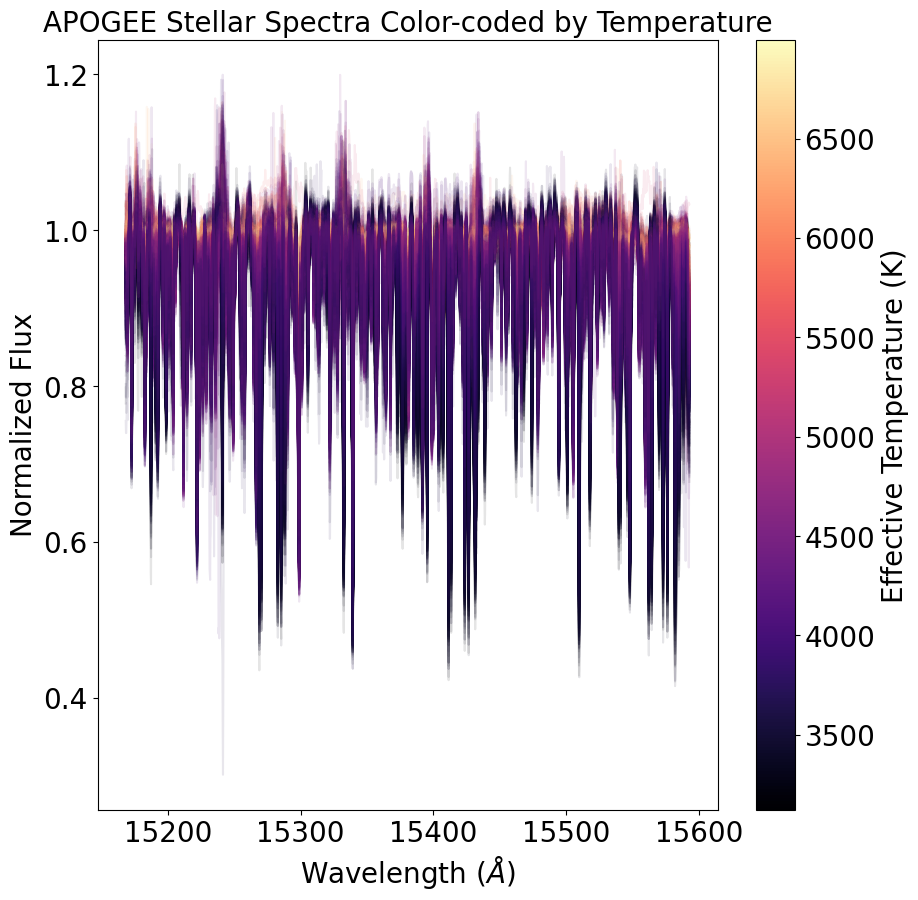

In [ ]:
# TODO: colors = plt.cm.plasma((teff_array - teff_min) / (teff_max - teff_min))
# TODO: Loop: ax.plot(wavelength, spectra[i], color=colors[i], alpha=0.3)
# TODO: Add colorbar with ScalarMappable
# TODO: Set labels and show

fig, ax = plt.subplots()
colors = plt.cm.magma((teff_array - teff_min) / (teff_max - teff_min))

for i in range(len(spectra)):
    ax.plot(wavelength, spectra[i], color=colors[i], alpha=0.1)

norm = plt.Normalize(teff_min, teff_max)
sm = plt.cm.ScalarMappable(cmap="magma", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Effective Temperature (K)')

ax.set_xlabel(r'Wavelength ($\AA$)')
ax.set_ylabel('Normalized Flux')
ax.set_title('APOGEE Stellar Spectra Color-coded by Temperature')
plt.show()

## Part 2: MLE Error Estimates

### Background
The maximum likelihood solution for linear regression is:

$$\mathbf{w}_{\text{ML}} = (\boldsymbol{\Phi}^T\boldsymbol{\Phi})^{-1}\boldsymbol{\Phi}^T\mathbf{t}$$

### Task 2a: Compute MLE and Naive Uncertainty Estimates

Implement the MLE solution and compute RMSE on training and test sets:

$$\sigma_{\text{naive}} = \sqrt{\frac{1}{N}\sum_{n=1}^N(t_n - \mathbf{w}_{\text{ML}}^T\boldsymbol{\phi}_n)^2}$$

In [ ]:
# TODO: Define fit_naive_mle(Phi_train, t_train, Phi_test, t_test)
# TODO: w_ml = np.linalg.inv(Phi_train.T @ Phi_train) @ Phi_train.T @ t_train
# TODO: pred_train = Phi_train @ w_ml, pred_test = Phi_test @ w_ml
# TODO: sigma_mle = sqrt(mean((t_train - pred_train)^2))
# TODO: rmse_test = sqrt(mean((t_test - pred_test)^2))
# TODO: Call function and print ratio rmse_test/sigma_mle

def fit_naive_mle(Phi_train, t_train, Phi_test, t_test):
    """
    Computes MLE solution and naive uncertainty estimates.
    """
    # Compute MLE weights
    w_ml = np.linalg.inv(Phi_train.T @ Phi_train) @ Phi_train.T @ t_train

    # Make predictions
    pred_train = Phi_train @ w_ml
    pred_test = Phi_test @ w_ml

    # Compute naive uncertainty (RMSE on training set)
    sigma_mle = np.sqrt(np.mean((t_train - pred_train)**2))

    # Compute RMSE on test set
    rmse_test = np.sqrt(np.mean((t_test - pred_test)**2))

    return sigma_mle, rmse_test, pred_train, pred_test, w_ml

sigma_mle, rmse_test, pred_train, pred_test, w_ml = fit_naive_mle(Phi_train, t_train, Phi_test, t_test)

print(f"Naive Uncertainty (sigma_mle): {sigma_mle:.2f}")
print(f"Test RMSE: {rmse_test:.2f}")
print(f"Ratio Test RMSE / sigma_mle: {rmse_test / sigma_mle:.2f}")

Naive Uncertainty (sigma_mle): 51.64
Test RMSE: 487.71
Ratio Test RMSE / sigma_mle: 9.44


### Task 2b: Visualize Residuals

Create two plots:
1. Histogram of training vs test residuals with Gaussian fits
2. Histogram of normalized test residuals compared to N(0,1)

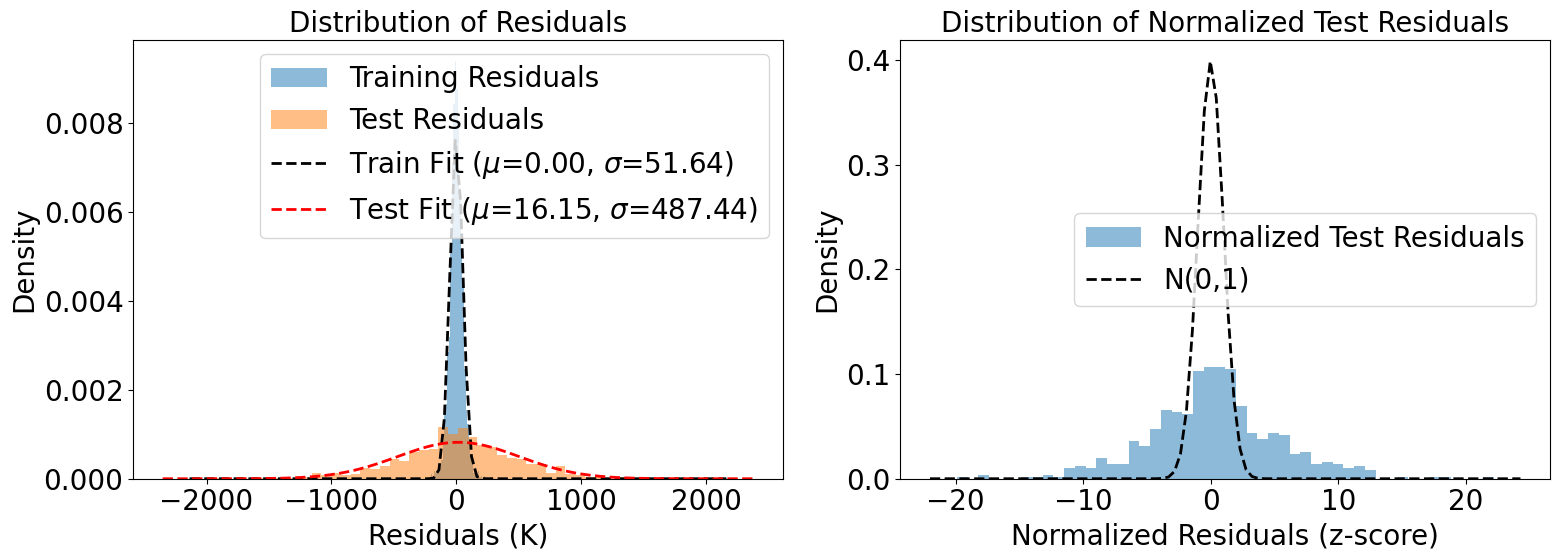

Standard deviation of normalized test residuals: 5.15


In [ ]:
# TODO: Create 2 subplots (1,2)
# TODO: Left: histogram of residuals_train and residuals_test with Gaussian overlays
# TODO: Right: histogram of (residuals_test / sigma_test) vs N(0,1)
# TODO: Show that normalized residuals have std >> 1.0

from scipy.stats import norm

residuals_train = t_train - pred_train
residuals_test = t_test - pred_test
normalized_residuals_test = residuals_test / sigma_test

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Histograms of training and test residuals with Gaussian fits
axes[0].hist(residuals_train, bins=50, alpha=0.5, label='Training Residuals', density=True)
axes[0].hist(residuals_test, bins=50, alpha=0.5, label='Test Residuals', density=True)

# Gaussian fit for training residuals
mu_train, std_train = norm.fit(residuals_train)
xmin_train, xmax_train = axes[0].get_xlim()
x_train = np.linspace(xmin_train, xmax_train, 100)
p_train = norm.pdf(x_train, mu_train, std_train)
axes[0].plot(x_train, p_train, 'k--', linewidth=2, label=rf'Train Fit ($\mu$={mu_train:.2f}, $\sigma$={std_train:.2f})')

# Gaussian fit for test residuals
mu_test, std_test = norm.fit(residuals_test)
xmin_test, xmax_test = axes[0].get_xlim()
x_test = np.linspace(xmin_test, xmax_test, 100)
p_test = norm.pdf(x_test, mu_test, std_test)
axes[0].plot(x_test, p_test, 'r--', linewidth=2, label=rf'Test Fit ($\mu$={mu_test:.2f}, $\sigma$={std_test:.2f})')

axes[0].set_xlabel('Residuals (K)')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution of Residuals')
axes[0].legend()

# Right plot: Histogram of normalized test residuals vs N(0,1)
axes[1].hist(normalized_residuals_test, bins=50, alpha=0.5, label='Normalized Test Residuals', density=True)

# Plot N(0,1)
xmin_norm, xmax_norm = axes[1].get_xlim()
x_norm = np.linspace(xmin_norm, xmax_norm, 100)
p_norm = norm.pdf(x_norm, 0, 1)
axes[1].plot(x_norm, p_norm, 'k--', linewidth=2, label='N(0,1)')

axes[1].set_xlabel('Normalized Residuals (z-score)')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution of Normalized Test Residuals')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Standard deviation of normalized test residuals: {np.std(normalized_residuals_test):.2f}")

**Question:** What do these plots tell us about the naive MLE approach? Why is the normalized residual distribution wider than expected?

It shows us that the data does not follow a simple normal distribution in the uncertainties introduced by the noise, meaning that some areas of the noise are larger than others, which leads to a broader distribution with a standard deviation greater than 1 that does not fit the normal probability curve exactly, and thus the original naive assumptions that the residuals follow such a distribution are wrong. There is some other level of independent relationships going on in this dataset that cannot be accurately modelled by this basic of an approach when separating out the parameterization for the noise vs. the signal.

## Part 3: Bayesian Linear Regression

### Background
Bayesian linear regression computes a posterior distribution:

$$p(\mathbf{w}|\mathbf{t}, \boldsymbol{\Phi}, \boldsymbol{\Sigma}) = \mathcal{N}(\mathbf{w}|\mathbf{m}_N, \mathbf{S}_N)$$

where:
- $\mathbf{S}_N = (\mathbf{S}_0^{-1} + \boldsymbol{\Phi}^T\boldsymbol{\Sigma}^{-1}\boldsymbol{\Phi})^{-1}$ (posterior covariance)
- $\mathbf{m}_N = \mathbf{S}_N(\boldsymbol{\Phi}^T\boldsymbol{\Sigma}^{-1}\mathbf{t})$ (posterior mean)
- $\mathbf{S}_0 = \eta^2\mathbf{I}$ (prior covariance)
- $\boldsymbol{\Sigma} = \text{diag}(\sigma_1^2, ..., \sigma_N^2)$ (measurement covariance)

### Task 3a: Compute Posterior Distribution

Implement the posterior computation for different prior strengths $\eta^2$ = [1000, 100000, 10000000].

In [ ]:
# TODO: Define compute_posterior(Phi, t, sigma, eta2)
# TODO: S0_inv = np.eye(M) / eta2
# TODO: Sigma_inv = np.diag(1 / sigma**2)
# TODO: S_N = np.linalg.inv(S0_inv + Phi.T @ Sigma_inv @ Phi)
# TODO: m_N = S_N @ (Phi.T @ Sigma_inv @ t)
# TODO: Loop eta2_values=[1e3, 1e5, 1e7], compute posteriors

def compute_posterior(Phi, t, sigma, eta2):
    """
    Computes the posterior distribution parameters (mean and covariance).
    """
    M = Phi.shape[1]
    S0_inv = np.eye(M) / eta2
    Sigma_inv = np.diag(1 / sigma**2)

    # Compute posterior covariance
    S_N = np.linalg.inv(S0_inv + Phi.T @ Sigma_inv @ Phi)

    # Compute posterior mean
    m_N = S_N @ (Phi.T @ Sigma_inv @ t)

    return m_N, S_N

eta2_values = [1e3, 1e5, 1e7]
posteriors = {}

for eta2 in eta2_values:
    m_N, S_N = compute_posterior(Phi_train, t_train, sigma_train, eta2)
    posteriors[eta2] = (m_N, S_N)
    print(f"For eta^2 = {eta2:.0e}: Posterior mean shape = {m_N.shape}, Posterior covariance shape = {S_N.shape}")

For eta^2 = 1e+03: Posterior mean shape = (2001,), Posterior covariance shape = (2001, 2001)
For eta^2 = 1e+05: Posterior mean shape = (2001,), Posterior covariance shape = (2001, 2001)
For eta^2 = 1e+07: Posterior mean shape = (2001,), Posterior covariance shape = (2001, 2001)


**Questions:**
- What do $\mathbf{m}_N$ and $\mathbf{S}_N$ represent?
- How does this compare to the naive MLE weights $\mathbf{w}_{\text{ML}}$?

m_N represents the posterior mean and S_N represents the posterior covariance, which together represent the posterior distribution over the model's weights after observing N data points. In terms of a Bayesian approach, this is a distribution of the data after it has been weighted and read by the model. The posterior mean represents a sort of mean vector of the posterior distribution, and the posterior covariance is a matrix of the posterior distribution measuring the uncertainty of the weighted values in the diagonalization of said matrix. Small covariance values correspond to a high degree of confidence, and large values are higher in uncertainty.

MLE weight is a derived quantity of the most probable weights for the observed data to fit the distribution seen in the training data, whereas Bayesian m_N and S_N is a distribution over said weights showing a vector value and an uncertainty in said value at each point, instead of a single point estimate of the weights at each point for MLE, which provides no measure for the uncertainty, just a "best guess". MLE does not incorporate any prior data in these weighted points and only goes off of the data, but m_N and S_N do use prior data regarding the weights in forming future weighted values.

### Task 3b: Visualize Spectral Weights

Plot the spectral weights with uncertainty bands (±2σ) for each prior strength.

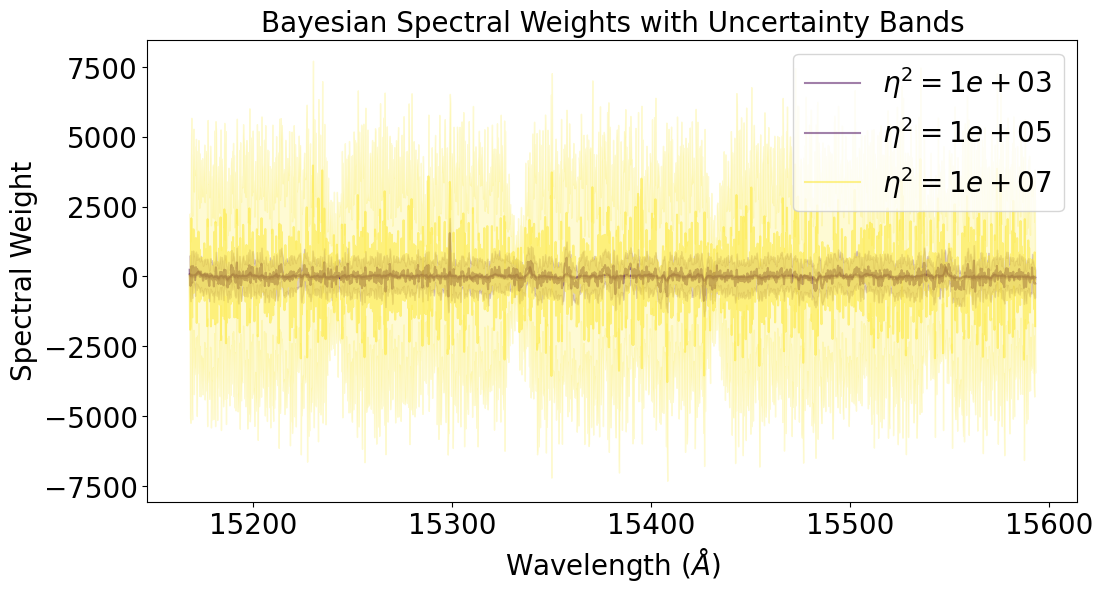

In [ ]:
# TODO: Loop posteriors: spectral_weights = m_N[:-1]
# TODO: weight_std = np.sqrt(np.diag(S_N[:-1, :-1]))
# TODO: plt.plot(wavelength, spectral_weights)
# TODO: plt.fill_between(wavelength, weights-2*std, weights+2*std, alpha=0.2)

fig, ax = plt.subplots(figsize=(12, 6))

# Define a colormap
cmap = plt.colormaps['viridis']
# Normalize eta2 values to the range [0, 1] for colormap
norm_eta2 = plt.Normalize(min(posteriors.keys()), max(posteriors.keys()))

for eta2, (m_N, S_N) in posteriors.items():
    spectral_weights = m_N[:-1]
    weight_std = np.sqrt(np.diag(S_N[:-1, :-1]))

    # Get color from colormap based on normalized eta2
    color = cmap(norm_eta2(eta2))

    ax.plot(wavelength, spectral_weights, label=rf'$\eta^2={eta2:.0e}$', color=color, alpha=0.5)
    ax.fill_between(wavelength, spectral_weights - 2 * weight_std, spectral_weights + 2 * weight_std, color=color, alpha=0.2)

ax.set_xlabel(r'Wavelength ($\AA$)')
ax.set_ylabel('Spectral Weight')
ax.set_title('Bayesian Spectral Weights with Uncertainty Bands')
ax.legend()
plt.show()

**Question:** Which $\eta^2$ provides the optimal balance? Why?

In my modelling of the data, the best fitting of the eta value ended up seeming like the middle value of 1e+05, based off the calculations below which show it has the highest coverage value. This is a balance between under-fitting and over-fitting the modelled data to the distribution, to find the best eta value which captures the full breadth of the data but without over-fitting it by having the learning rate be too high, potentially creating a model that does fit but is overly complicated in its approach. I feel like in the ideal case, one would sample over many eta values to find a maximal value of coverage at a minimal value of eta which would satisfy a best fit model to the data without making it an over-generalization of the data it is predicting. This would allow for the highest predictive power of the model to be applied to future data of the same kind.

## Part 4: Making Bayesian Predictions with Uncertainty

### Background
The predictive distribution is:

$$p(t_*|\boldsymbol{\phi}_*, \mathcal{D}) = \mathcal{N}(t_*|\mu_*, \sigma_*^2)$$

with:
- Mean: $\mu_* = \mathbf{m}_N^T\boldsymbol{\phi}_*$
- Variance: $\sigma_*^2 = \sigma_{\text{obs},*}^2 + \boldsymbol{\phi}_*^T\mathbf{S}_N\boldsymbol{\phi}_* + \sigma_{\text{model}}^2$

### Task 4a: Implement Prediction Function

In [ ]:
# TODO: Define predict_with_uncertainty(Phi_new, sigma_new, m_N, S_N, sigma_model)
# TODO: pred_mean = Phi_new @ m_N
# TODO: param_var = np.sum(Phi_new @ S_N * Phi_new, axis=1)
# TODO: pred_var = param_var + sigma_new**2 + sigma_model**2
# TODO: Return pred_mean, np.sqrt(pred_var)

def predict_with_uncertainty(Phi_new, sigma_new, m_N, S_N, sigma_model):
    """
    Makes predictions with uncertainty using Bayesian linear regression.
    """
    # Predictive mean
    pred_mean = Phi_new @ m_N

    # Predictive variance
    param_var = np.sum(Phi_new @ S_N * Phi_new, axis=1)
    pred_var = param_var + sigma_new**2 + sigma_model**2 # Added sigma_model here

    return pred_mean, np.sqrt(pred_var)

### Task 4b: Visualize Predictions with Uncertainties

Plot predicted vs true temperatures with uncertainty bands.

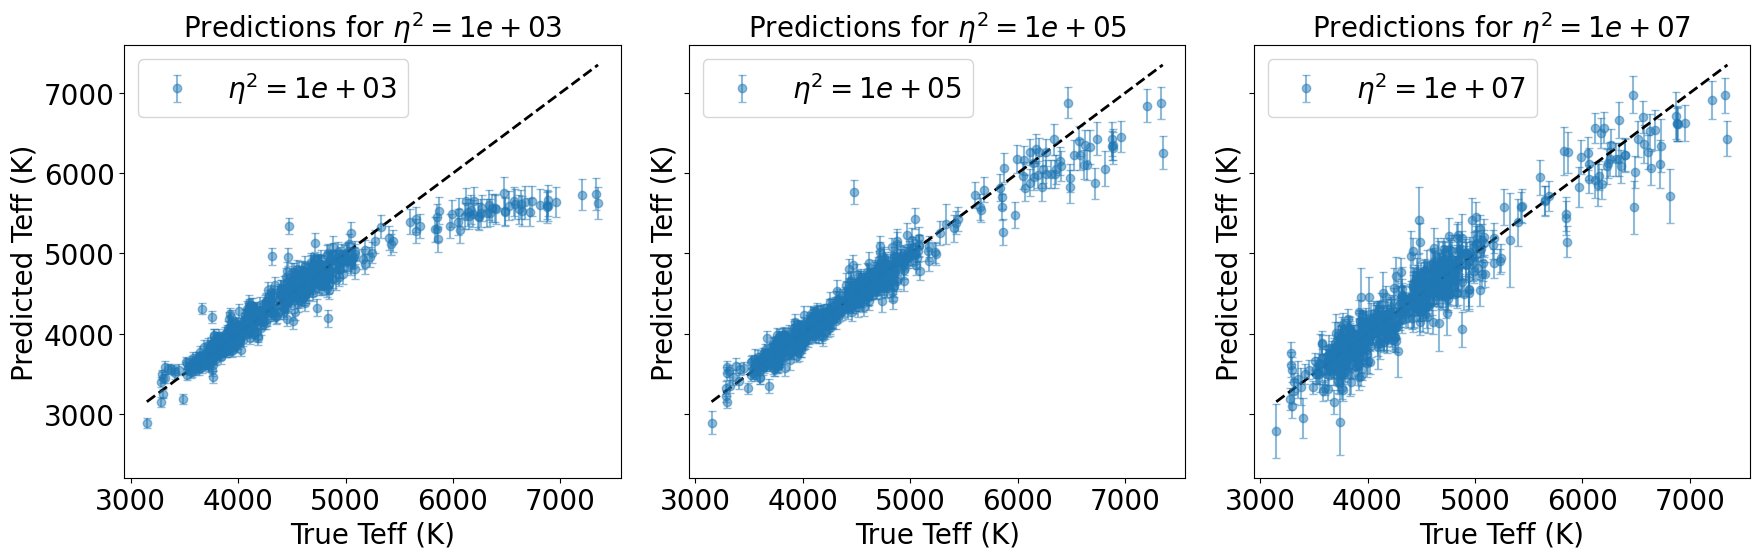

In [ ]:
# TODO: Loop posteriors, get pred_mean and pred_std
# TODO: plt.scatter(t_test, pred_mean), add y=x line
# TODO: rmse = np.sqrt(np.mean((t_test - pred_mean)**2))
# TODO: z_scores = (t_test - pred_mean) / pred_std
# TODO: coverage = np.mean(np.abs(z_scores) < 2)

fig, axes = plt.subplots(1, len(posteriors), figsize=(6 * len(posteriors), 6), sharex=True, sharey=True)
axes = axes.flatten() if len(posteriors) > 1 else [axes]

for i, (eta2, (m_N, S_N)) in enumerate(posteriors.items()):
    # Assume sigma_model is 0 for now, will address in Task 4c
    pred_mean, pred_std = predict_with_uncertainty(Phi_test, sigma_test, m_N, S_N, sigma_model=0)

    axes[i].errorbar(t_test, pred_mean, yerr=pred_std, fmt='o', alpha=0.5, label=rf'$\eta^2={eta2:.0e}$', capsize=3)
    axes[i].plot([t_test.min(), t_test.max()], [t_test.min(), t_test.max()], 'k--', lw=2) # y=x line
    axes[i].set_xlabel('True Teff (K)')
    axes[i].set_ylabel('Predicted Teff (K)')
    axes[i].set_title(rf'Predictions for $\eta^2={eta2:.0e}$')
    axes[i].legend()

plt.tight_layout()
plt.show()

### Task 4c: Calculate Coverage

Compute the 95% coverage using Z-scores:

$$z = \frac{t_{\text{true}} - t_{\text{predicted}}}{\sigma_{\text{predicted}}}$$

For well-calibrated uncertainties, ~95% of z-scores should have |z| < 2.

In [ ]:
# TODO: Loop posteriors
# TODO: Get predictions, calculate z_scores and coverage
# TODO: Print f"η²={eta2:.0e}: RMSE={rmse:.1f}K, Coverage={coverage:.3f}"

for eta2, (m_N, S_N) in posteriors.items():
    pred_mean, pred_std = predict_with_uncertainty(Phi_test, sigma_test, m_N, S_N, sigma_model=0)

    rmse = np.sqrt(np.mean((t_test - pred_mean)**2))
    z_scores = (t_test - pred_mean) / pred_std
    coverage = np.mean(np.abs(z_scores) < 2) # 95% coverage (within 2 standard deviations)

    print(f"η²={eta2:.0e}: RMSE={rmse:.1f}K, Coverage={coverage:.3f}")

η²=1e+03: RMSE=294.8K, Coverage=0.813
η²=1e+05: RMSE=166.4K, Coverage=0.910
η²=1e+07: RMSE=220.4K, Coverage=0.892


**Questions:**
- Which prior gives the best coverage?
- What does coverage < 0.95 indicate?
- What does coverage > 0.95 indicate?

The best coverage is given by eta^2 of 1e+05, with a coverage of 0.910. The coverage represents the confidence amount of the true values of the data that would fit within the predictive model itself, such that a value below 0.95 would indicate that less than 95% of all the data fits within the uncertainty of the models predictions, and a value over 0.95 would have over 95% of the data fitting to the model. If your goal was to achieve a 95% coverage of the data and you arrived at values of 0.85, 0.952, and 0.98, the best fit value would be the 0.952 which would correspond to a balance between underfitting and overfitting the confidence level of the model. Making a model to be too precise or not precise enough are both potentially problematic when training these models, so it is important to arrive at a value as close to the predictive power as is necessary as possible without training it to be too narrow or too wide in its predictive power.

## Bonus: Visualize Z-score Distribution

### Task 4d: Plot Z-scores

Compare the z-score distribution to the expected N(0,1).

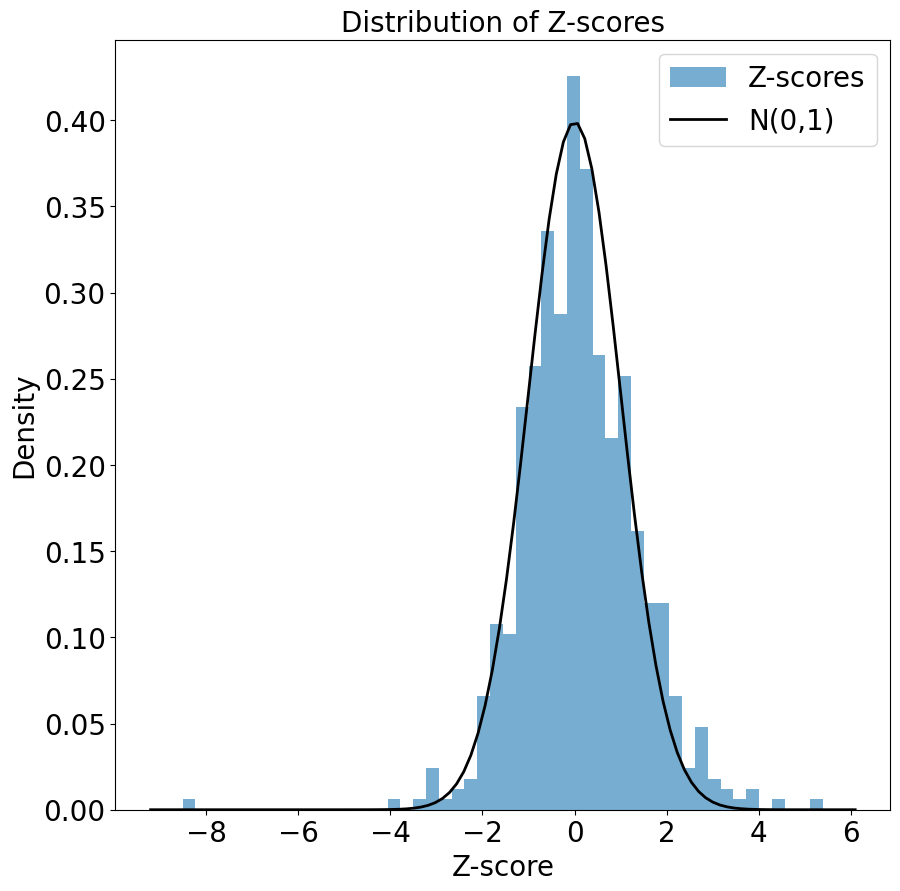

Mean of Z-scores: 0.11
Standard deviation of Z-scores: 1.25


In [ ]:
# TODO: m_N_opt, S_N_opt = posteriors[1]  # eta2=1e5
# TODO: Get predictions and z_scores = (t_test - pred_mean) / pred_std
# TODO: plt.hist(z_scores), overlay (1/sqrt(2π)) * exp(-x²/2)
# TODO: Print mean and std of z_scores (should be ~0 and ~1)

# Select the posterior with the best coverage (eta2=1e5 based on previous output)
m_N_opt, S_N_opt = posteriors[1e5]

# Get predictions and z_scores for the optimal prior
pred_mean, pred_std = predict_with_uncertainty(Phi_test, sigma_test, m_N_opt, S_N_opt, sigma_model=0)
z_scores = (t_test - pred_mean) / pred_std

# Plot histogram of z-scores and overlay N(0,1)
plt.hist(z_scores, bins=50, density=True, alpha=0.6, label='Z-scores')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, 0, 1)
plt.plot(x, p, 'k', linewidth=2, label='N(0,1)')

plt.xlabel('Z-score')
plt.ylabel('Density')
plt.title('Distribution of Z-scores')
plt.legend()
plt.show()

# Print mean and standard deviation of z-scores
print(f"Mean of Z-scores: {np.mean(z_scores):.2f}")
print(f"Standard deviation of Z-scores: {np.std(z_scores):.2f}")

**Question:** Are your uncertainties well-calibrated? How can you tell?

We are trying to fit the Z-scores to a model that represents a normal distribution as closely as possible, within a margin of error introduced by an optimal uncertainty in the training data we are fitting. Given that an optimal normal distribution would have a mean value of 0 from the center of the distribution, and a standard deviation of 1, we have achieved a value fairly close to this amount. The mean of 0.11 means this data is slightly off from the perfect value of 0 for the base normal distribution, and it is slightly wider in terms of the standard deviation or spread of the data, but it is still remarkably close and within roughly a margin of error. Given that the optimal coverage rate we arrived at for the uncertainty is around 0.910 from the above eta values, this represents around a 9% deviation from a purely normal distribution which we would expect at coverage 1.0, or 100% certainty in the spread of the data. I would say that this model fits the bill for the coverage that it proports, and it is reasonably well-calibrated.

## Summary and Conclusions

**Key Takeaways:**

1. **Naive MLE fails:** Training RMSE severely underestimates prediction uncertainty due to overfitting

2. **Bayesian approach:** Properly accounts for parameter uncertainty, measurement noise, and model inadequacy

3. **Prior selection:** The prior strength $\eta^2$ controls the balance between flexibility and regularization

4. **Calibration matters:** Well-calibrated uncertainties are essential for scientific inference

5. **Uncertainty decomposition:** Understanding different sources of error helps guide improvement efforts

**Your findings:**

[Write your conclusions here - which prior was optimal? What was the final RMSE and coverage?]

The most optimal prior we calculated in this lab was the eta of 1e+05, which resulted in a final coverage of 0.910 and an RMSE of 166.4K. While this is slightly shy of the ~95% coverage people may often use for scientific modelling, we could potentially achieve a value close to this by introducing an intermediate eta model through an iterative approach which samples the coverage convergence in a range of eta values when training the models. There may be one or more values that improve upon our eta of 1e+05 since we were using highly rounded and particular values of eta just to illustrate a point here. Ideally, we would want to pick a value which maximized the coverage to a degree of uncertainty that we deemed tolerable and which best fit our goal of modelling the data, without over- or under-fitting the model to be too narrow or broad in its predictive scope. This would then result in an RMSE value which was lower than the one achieved here in terms of the absolute temperature difference from true values in future data based off of our prior models. Ultimately, a model such as this could be used to process further spectral data of stellar objects and determine with a high degree of certainty what their temperature would be, despite the noise introduced by various parameters in said data and regardless of things like the distance of said stars from us or the flux in said spectral data.